In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

from tqdm import tqdm
import os
import cv2
from random import shuffle
import time

from sklearn import linear_model, metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

import tensorflow as tf
import keras
# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K
from tensorboardcolab import *


In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def create_train():
    normal_data=[]
    pneumonia_data=[]
    for img in tqdm(os.listdir(normal_train)):
        path = os.path.join(normal_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        normal_data.append(np.array(img))
    for img in tqdm(os.listdir(pneumonia_train)):
        path = os.path.join(pneumonia_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        pneumonia_data.append(np.array(img))
    training_data = normal_data + pneumonia_data
    np.save('train_datanew.npy', training_data)
    return training_data
        

In [0]:
train_data = np.load('/content/drive/My Drive/Datasets/train_data.npy')
labels = np.load('/content/drive/My Drive/Datasets/labels.npy')
train_data

In [0]:
X = train_data
Y = labels

In [0]:
X = X.reshape(5216,50,50, 1).astype('float32')/255
Y = labels
X

In [0]:
X, Y = shuffle(X, Y, random_state=0)

In [9]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://3457dd4e.ngrok.io


In [0]:
denselayers = [0,1,2]
nodes = [32,64,128]
convlayers = [2,3,4]

for denselayer in denselayers:
  for node in nodes:
    for convlayer in convlayers:
      
      NAME = '{}-conv-{}-nodes-{}-dense{}'.format(convlayer, node, denselayer, int(time.time()))
      print(NAME)
      model = Sequential()
      model.add(Conv2D(node,(3,3), activation='relu',  input_shape=(50,50,1)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      
      for l in range(convlayer-1):
        model.add(Conv2D(node,(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
      
      model.add(Flatten())
      for l in range(denselayer):
        model.add(Dense(256, activation='relu'))
      
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      
      model.fit(X, Y, batch_size=16, epochs=10, verbose=1,validation_split=.1, callbacks=[TensorBoardColabCallback(tbc)])
      
      


2-conv-32-nodes-0-dense1547104445
Train on 4694 samples, validate on 522 samples
Epoch 1/10
4694/4694 [==============================] - 16s 3ms/step - loss: 0.3171 - acc: 0.8598 - val_loss: 0.1303 - val_acc: 0.9540
Epoch 2/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.1294 - acc: 0.9506 - val_loss: 0.1757 - val_acc: 0.9195
Epoch 3/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.1060 - acc: 0.9599 - val_loss: 0.1073 - val_acc: 0.9521
Epoch 4/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.1003 - acc: 0.9599 - val_loss: 0.0925 - val_acc: 0.9674
Epoch 5/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.0897 - acc: 0.9674 - val_loss: 0.0939 - val_acc: 0.9655
Epoch 6/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.0890 - acc: 0.9636 - val_loss: 0.0842 - val_acc: 0.9732
Epoch 7/10
4694/4694 [==============================] - 15s 3ms/step - loss: 0.0754 - acc: 0.9721 - val_loss:

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

model_json = model.to_json()
with open("/content/drive/My Drive/Datasets/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Datasets/model.h5")
print("Saved model to drive")

/bin/bash: google-drive-ocamlfuse: command not found
Saved model to drive


In [0]:
import pickle

save_model = open('/content/drive/My Drive/Datasets/model.pickle', 'wb')
pickle.dump(model, save_model)
save_model.close()

In [99]:
#4 Conv layers w/ 64 nodes and 1 dense layer run with 6 epochs had the best validation accuracy and lowest loss

denselayers = [1]
nodes = [64]
convlayers = [4]

for denselayer in denselayers:
  for node in nodes:
    for convlayer in convlayers:
      
      NAME = '{}-conv-{}-nodes-{}-dense{}'.format(convlayer, node, denselayer, int(time.time()))
      print(NAME)
      model = Sequential()
      model.add(Conv2D(node,(3,3), activation='relu',  input_shape=(50,50,1)))
      model.add(MaxPooling2D(pool_size=(2,2)))
      
      for l in range(convlayer-1):
        model.add(Conv2D(node,(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
      
      model.add(Flatten())
      for l in range(denselayer):
        model.add(Dense(256, activation='relu'))
      
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      
      model.fit(X, Y, batch_size=16, epochs=6, verbose=1,validation_split=.1, callbacks=[TensorBoardColabCallback(tbc)])

4-conv-64-nodes-1-dense1547150712
Train on 4694 samples, validate on 522 samples
Epoch 1/6
4694/4694 [==============================] - 33s 7ms/step - loss: 0.4582 - acc: 0.7836 - val_loss: 0.3017 - val_acc: 0.8602
Epoch 2/6
4694/4694 [==============================] - 33s 7ms/step - loss: 0.1901 - acc: 0.9244 - val_loss: 0.1416 - val_acc: 0.9425
Epoch 3/6
4694/4694 [==============================] - 33s 7ms/step - loss: 0.1344 - acc: 0.9480 - val_loss: 0.1035 - val_acc: 0.9579
Epoch 4/6
4694/4694 [==============================] - 33s 7ms/step - loss: 0.0981 - acc: 0.9663 - val_loss: 0.0846 - val_acc: 0.9693
Epoch 5/6
4694/4694 [==============================] - 33s 7ms/step - loss: 0.0766 - acc: 0.9734 - val_loss: 0.0762 - val_acc: 0.9693
Epoch 6/6
4694/4694 [==============================] - 34s 7ms/step - loss: 0.0728 - acc: 0.9742 - val_loss: 0.0760 - val_acc: 0.9732


In [0]:
testdata = np.load('/content/drive/My Drive/Datasets/xraytest (1).npy')
testlabels = np.load('/content/drive/My Drive/Datasets/xraytestlabels.npy')
testdata

In [0]:
#shuffle the data to avoid bias

from sklearn.utils import shuffle
Xtest, Ytest = shuffle(testdata, testlabels, random_state=0)

In [0]:
Xtest = Xtest.reshape(-1,50,50,1)/255
Xtest

In [126]:
predy = model.predict(Xtest)
scores = model.evaluate(Xtest, Ytest)
print('Loss', scores[0])
print('Accuracy', scores[1])

624/624 [==============================] - 1s 2ms/step
Loss 0.7385539229099567
Accuracy 0.7964743589743589


In [127]:
predy = np.round_(predy, decimals=0)
predy

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],

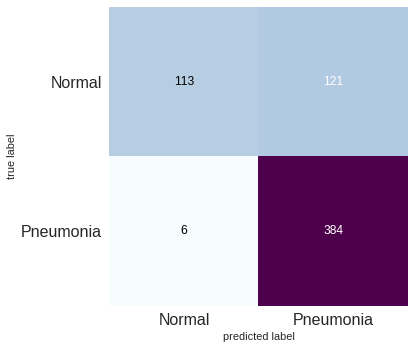

In [129]:

conf = confusion_matrix(Ytest, predy)
plt.figure()
plot_confusion_matrix(conf, hide_ticks=True, cmap=plt.cm.BuPu)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()


In [131]:
tn, fp, fn, tp = conf.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall: {:.2f}".format(recall))
print("Precision: {:.2f}".format(precision))

Recall: 0.98
Precision: 0.76


# Addressing Class imbalance

Here I resample the pneumonia class to be equal to the normal class.

In [0]:
def create_trainUS():
    normal_data=[]
    pneumonia_data=[]
    for img in tqdm(os.listdir(normal_train)):
        path = os.path.join(normal_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        normal_data.append(np.array(img))
    for img in tqdm(os.listdir(pneumonia_train)):
        path = os.path.join(pneumonia_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        pneumonia_data.append(np.array(img))
    shuffle(pneumonia_data)
    training_data = normal_data + pneumonia_data[0:1341]
    np.save('train_dataUS.npy', training_data)
    return training_data
        

In [0]:
training_Data = create_trainUS()

NameError: ignored

In [0]:
training_data = np.array(training_Data)
training_data = training_data.reshape(2682, 28*28)

USlabels = [0] *1341 + [1] *1341
Y = np.array(USlabels)

X = training_data
X, Y = nudge_dataset(X,Y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.3)

In [0]:
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# Training
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# Plotting
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Conclusion
Overall Logistic regression on the raw image files outperformed the RBM extracted images. Further tweaking of the RBM parameters such as increasing n_components may increase performance.

There was a class imbalance ~ 3:1 pneunomia:normal that caused logistic regression on RBM features to only predict pneumonia. After correcting for the class imbalance by creating a random sample of pneumonia images the same length as normal images we saw a more accurate prediction. RBM features still performed worse than the raw image files (82% recall and precision vs 91%/93% precision/recall of raw images). 

Shifting the images to artificially create new training data is also a questionable practice. The shifted images should be the same as the original images and be weighted equally which should lead to the same performance, but instead we saw a significant increase in performance.

Another factor to consider is the effect that image size may have on performance. a 28x28 image shifted 1 pixel will have a much greater difference than a 100x100 image shifted 1 pixel. Further exploration of image size should also be explored.